In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Data preprocessing

In [3]:
data = pd.read_csv("CGMData.csv")

In [4]:
data.head()

7.3723e+05  7.3723e+05.1  7.3723e+05.2  7.3723e+05.3  7.3723e+05.4  \
0         136           135           136           135           134   

   7.3723e+05.5  7.3723e+05.6  7.3723e+05.7  7.3723e+05.8  7.3723e+05.9  ...  \
0           133           130           129           127           126  ...   

   7.37e+05.1159  7.37e+05.1160  7.37e+05.1161  7.37e+05.1162  7.37e+05.1163  \
0            100            100            100            101            102   

   7.37e+05.1164  7.37e+05.1165  7.37e+05.1166  7.37e+05.1167  7.37e+05.1168  
0            101             98             95             91             89  

[1 rows x 44845 columns]

In [5]:
def stampToString(x):  
    d = datetime.fromtimestamp(x)
    return d.strftime("%m.%d.%Y %H:%M:%S")

In [6]:
values = [float(i) if np.isfinite(i) else 0 for i in data.values[0]]
# starting from 2018-06-16 09:20, every 5 minutes 
based_t = 1529140800  # 2018-06-16 09:20
pairs = []
print("len of the values:", len(values))

for i in range(len(values)):
    t = based_t + i * 300
    pairs.append((stampToString(t), values[i])) 

len of the values: 44845


In [7]:
pairs = pd.DataFrame(data=pairs, columns=['Date', 'Sensor'])
pairs.Sensor = pairs.Sensor.astype(float)
pairs.head()

Date  Sensor
0  06.16.2018 02:20:00   136.0
1  06.16.2018 02:25:00   135.0
2  06.16.2018 02:30:00   136.0
3  06.16.2018 02:35:00   135.0
4  06.16.2018 02:40:00   134.0

In [8]:
pairs = pairs.set_index(['Date'])
pairs.index = pd.to_datetime(pairs.index)
pairs.head()

Sensor
Date                       
2018-06-16 02:20:00   136.0
2018-06-16 02:25:00   135.0
2018-06-16 02:30:00   136.0
2018-06-16 02:35:00   135.0
2018-06-16 02:40:00   134.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1449a3590>],
      dtype=object)

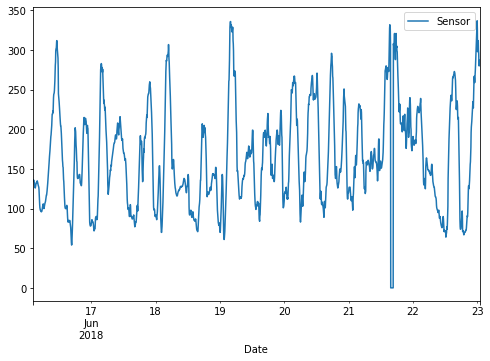

In [9]:
pairs[:2000].plot(subplots=True)

In [10]:
TRAIN_SPLIT = int(len(pairs.values) / 4 * 3)

dataset = pairs.values
dataset_mean = dataset[:TRAIN_SPLIT].mean()
dataset_std = dataset[:TRAIN_SPLIT].std()

dataset = (dataset - dataset_mean) / dataset_std

In [11]:
print(dataset)

[[-0.35983643]
 [-0.37505686]
 [-0.35983643]
 ...
 [-0.98387436]
 [-1.04475611]
 [-1.07519698]]


In [12]:
def mulvariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i: i+target_size])
    return np.array(data), np.array(labels)

In [13]:
# use the data of past 3 hours to predict future 1 hour
history_size = 36
target_size = 12

x_train, y_train = mulvariate_data(dataset, 0, TRAIN_SPLIT, history_size, target_size)
x_val, y_val = mulvariate_data(dataset, TRAIN_SPLIT, None, history_size, target_size)

In [14]:
print('Single window of past history : {}'.format(x_train[0]), x_train.shape)
print('Target to predict : {}'.format(y_train[0]), y_train.shape)

Single window of past history : [[-0.35983643]
 [-0.37505686]
 [-0.35983643]
 [-0.37505686]
 [-0.3902773 ]
 [-0.40549774]
 [-0.45115905]
 [-0.46637949]
 [-0.49682036]
 [-0.5120408 ]
 [-0.49682036]
 [-0.46637949]
 [-0.43593861]
 [-0.42071818]
 [-0.42071818]
 [-0.40549774]
 [-0.40549774]
 [-0.3902773 ]
 [-0.37505686]
 [-0.3902773 ]
 [-0.40549774]
 [-0.43593861]
 [-0.45115905]
 [-0.46637949]
 [-0.48159993]
 [-0.49682036]
 [-0.54248168]
 [-0.64902474]
 [-0.7555678 ]
 [-0.83166999]
 [-0.89255174]
 [-0.92299261]
 [-0.93821305]
 [-0.93821305]
 [-0.95343348]
 [-0.95343348]] (33597, 36, 1)
Target to predict : [[-0.96865392]
 [-0.96865392]
 [-0.95343348]
 [-0.95343348]
 [-0.92299261]
 [-0.90777217]
 [-0.8773313 ]
 [-0.84689042]
 [-0.83166999]
 [-0.81644955]
 [-0.83166999]
 [-0.8773313 ]] (33597, 12, 1)


In [15]:
def create_time_steps(length):
    return list(range(-length, 0))


def multi_step_plot(history, true_future, prediction, step=1):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out) / step, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out) / step, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [16]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

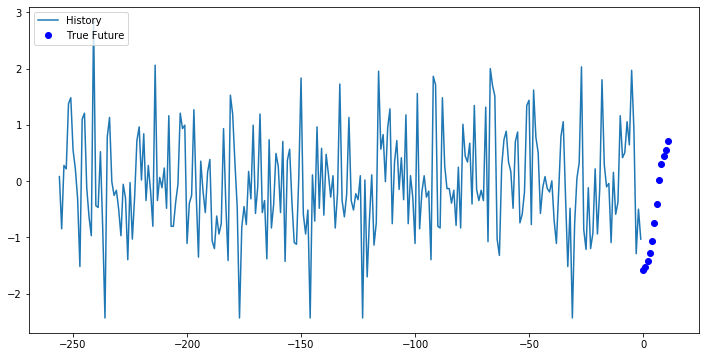

(256, 36, 1) (256, 12, 1)


In [17]:
for x, y in train_data.take(1):
    multi_step_plot(x, y[0], np.array([0]))
    print(x.shape, y.shape)

In [18]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(target_size))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [19]:
for x, y in val_data.take(1):
    print(multi_step_model.predict(x).shape)

(256, 12)


In [21]:
EPOCHS = 100
EVALUATION_INTERVAL = 200

multi_step_history = multi_step_model.fit(train_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/100
200/200 [==============================] - 9s 43ms/step - loss: 0.3558 - val_loss: 0.3161
Epoch 2/100
200/200 [==============================] - 10s 51ms/step - loss: 0.3325 - val_loss: 0.3028
Epoch 3/100
200/200 [==============================] - 8s 42ms/step - loss: 0.3231 - val_loss: 0.3143
Epoch 4/100
200/200 [==============================] - 9s 43ms/step - loss: 0.3153 - val_loss: 0.2958
Epoch 5/100
200/200 [==============================] - 9s 43ms/step - loss: 0.3128 - val_loss: 0.2956
Epoch 6/100
200/200 [==============================] - 9s 43ms/step - loss: 0.3097 - val_loss: 0.3072
Epoch 7/100
200/200 [==============================] - 9s 43ms/step - loss: 0.3069 - val_loss: 0.2896
Epoch 8/100
200/200 [==============================] - 9s 43ms/step - loss: 0.3061 - val_loss: 0.2928
Epoch 9/100
200/200 [==============================] - 8s 42ms/step - loss: 0.3037 - val_loss: 0.2870
Epoch 10/100
200/200 [================

200/200 [==============================] - 8s 38ms/step - loss: 0.2654 - val_loss: 0.2976
Epoch 81/100
200/200 [==============================] - 8s 38ms/step - loss: 0.2650 - val_loss: 0.2916
Epoch 82/100
200/200 [==============================] - 8s 38ms/step - loss: 0.2657 - val_loss: 0.3009
Epoch 83/100
200/200 [==============================] - 8s 40ms/step - loss: 0.2641 - val_loss: 0.2954
Epoch 84/100
200/200 [==============================] - 8s 39ms/step - loss: 0.2644 - val_loss: 0.2982
Epoch 85/100
200/200 [==============================] - 8s 39ms/step - loss: 0.2617 - val_loss: 0.2950
Epoch 86/100
200/200 [==============================] - 8s 39ms/step - loss: 0.2648 - val_loss: 0.2996
Epoch 87/100
200/200 [==============================] - 8s 39ms/step - loss: 0.2605 - val_loss: 0.2943
Epoch 88/100
200/200 [==============================] - 8s 39ms/step - loss: 0.2628 - val_loss: 0.3003
Epoch 89/100
200/200 [==============================] - 8s 39ms/step - loss: 0.2592 - 

In [22]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

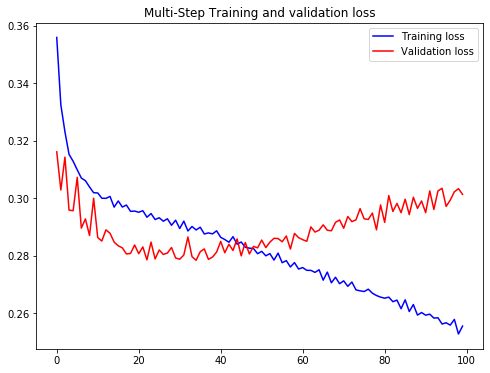

In [23]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

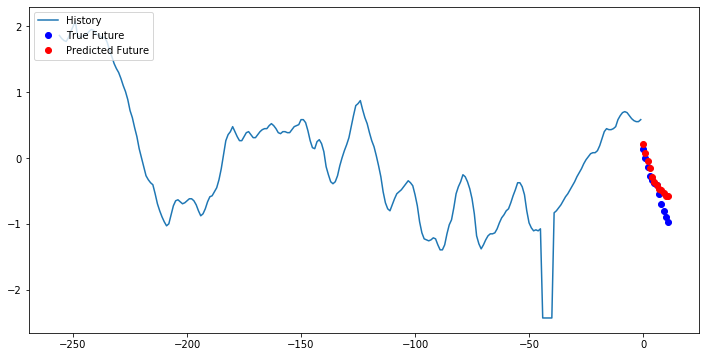

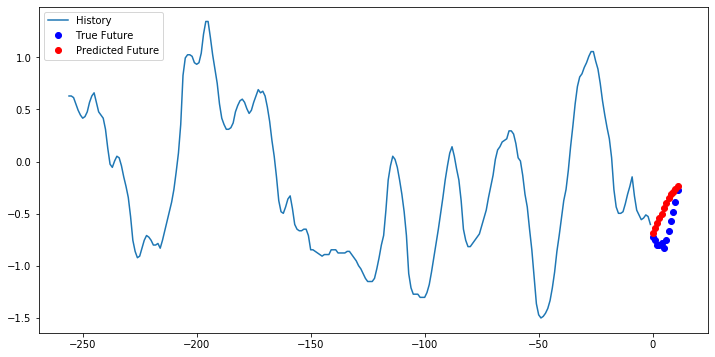

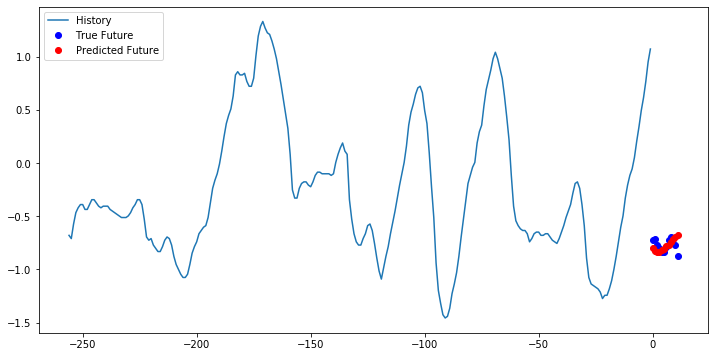

In [24]:
for x, y in val_data.take(3):
    multi_step_plot(x, y[0], multi_step_model.predict(x)[0])